# Fleet Optimization for Transportation



## Objective

Find the optimal combination of vehicles to minimize costs while maintaining an acceptable waiting time for passengers.

**Available Vehicles:**
- **Bus A**: 37 seats, 6:00-17:00 (11h), $42.6/h, Quantity: 1
- **Bus B**: 31 seats, 8:00-14:00 (6h), $42.6/h, Quantity: 2
- **Van A**: 19 seats, 6:00-20:00 (14h), $24.8/h, Quantity: 1
- **Van B**: 13 seats, 7:00-22:00 (15h), $24.8/h, Quantity: 3

**Usage Priority**: Bus A > Vans B > Bus B > Van A

**Constraint**: Service coverage must be provided from 6:00 to 22:00


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import product

np.random.seed(42)
sns.set_style('whitegrid')

## Vehicle Definition


In [ ]:
class VehicleType:
    def __init__(self, name, capacity, start_min, end_min, cost_per_hour, max_available, priority):
        """
        name: vehicle name
        capacity: passenger capacity
        start_min: start minute (from 6am, 0=6am, 60=7am, etc.)
        end_min: end minute
        cost_per_hour: cost per hour of operation
        max_available: maximum quantity available
        priority: usage priority (1=highest priority)
        """
        self.name = name
        self.capacity = capacity
        self.start_min = start_min
        self.end_min = end_min
        self.cost_per_hour = cost_per_hour
        self.max_available = max_available
        self.priority = priority
        
    def is_working(self, minute):
        """Checks if the vehicle is working at this minute"""
        return self.start_min <= minute < self.end_min
    
    def hours_worked(self):
        """Total work hours"""
        return (self.end_min - self.start_min) / 60
    
    def daily_cost(self):
        """Total cost per day of operation"""
        return self.hours_worked() * self.cost_per_hour
    
    def __repr__(self):
        start_h = 6 + self.start_min // 60
        end_h = 6 + self.end_min // 60
        return f"{self.name} (Cap:{self.capacity}, {start_h}:00-{end_h}:00, ${self.cost_per_hour}/h)"

# Define vehicles according to specifications
VEHICLES = [
    VehicleType('Bus A', capacity=37, start_min=0, end_min=660, cost_per_hour=42.6, max_available=1, priority=1),
    VehicleType('Bus B', capacity=31, start_min=120, end_min=480, cost_per_hour=42.6, max_available=2, priority=3),
    VehicleType('Van A', capacity=19, start_min=0, end_min=840, cost_per_hour=24.8, max_available=1, priority=4),
    VehicleType('Van B', capacity=13, start_min=60, end_min=960, cost_per_hour=24.8, max_available=3, priority=2),
]

# Display vehicle information
print("AVAILABLE VEHICLES:")
print("="*90)
for v in sorted(VEHICLES, key=lambda x: x.priority):
    start_h = 6 + v.start_min // 60
    end_h = 6 + v.end_min // 60
    print(f"Priority {v.priority} | {v.name:12} | Cap: {v.capacity:2} | "
          f"Schedule: {start_h:2}:00-{end_h:2}:00 | ${v.cost_per_hour}/h | "
          f"Cost/day: ${v.daily_cost():6.2f} | Available: {v.max_available}")


VEHÍCULOS DISPONIBLES:
Prioridad 1 | Autobús A    | Cap: 37 | Horario:  6:00-17:00 | $42.6/h | Costo/día: $468.60 | Disponibles: 1
Prioridad 2 | Camioneta B  | Cap: 13 | Horario:  7:00-22:00 | $24.8/h | Costo/día: $372.00 | Disponibles: 3
Prioridad 3 | Autobús B    | Cap: 31 | Horario:  8:00-14:00 | $42.6/h | Costo/día: $255.60 | Disponibles: 2
Prioridad 4 | Camioneta A  | Cap: 19 | Horario:  6:00-20:00 | $24.8/h | Costo/día: $347.20 | Disponibles: 1


## Load Real Bus Arrival Data


In [ ]:
class BusArrivalData:
    def __init__(self, data_files):
        """
        data_files: dict with format {(start_min, end_min): 'file.csv'}
        """
        self.data_files = data_files
        self.period_data = {}
        
        # Load data for each period
        for period, file in data_files.items():
            data = pd.read_csv(file, header=None).squeeze().values
            self.period_data[period] = data
    
    def generate_arrivals(self, total_minutes=960):
        """Generates interarrival times using empirical sampling"""
        arrival_times = []
        current_time = 0.0
        
        while current_time < total_minutes:
            # Determine which period we are in
            data_to_use = None
            for (start, end), data in self.period_data.items():
                if start <= current_time < end:
                    data_to_use = data
                    break
            
            if data_to_use is None:
                data_to_use = list(self.period_data.values())[-1]
            
            # Sample interarrival time
            interarrival = np.random.choice(data_to_use)
            arrival_times.append(interarrival)
            current_time += interarrival
        
        return np.array(arrival_times)

# Define data files by period
data_files = {
    (0, 180): 'data/glaxo_6-9_full.csv',
    (180, 480): 'data/glaxo_9-2_full.csv',
    (480, 720): 'data/glaxo_2-6_full.csv',
    (720, 960): 'data/glaxo_6-10_full.csv'
}

bus_data = BusArrivalData(data_files)


## Passenger Arrival Generation


In [ ]:
def generate_passenger_arrivals(total_minutes=960):
    """Generates passenger arrivals using non-homogeneous Poisson process"""
    arrival_times = []
    time = 0.0
    
    while time < total_minutes:
        if 0 <= time < 120:  # 6:00-8:00
            lmda = 3.0
        elif 120 <= time < 240:  # 8:00-10:00
            lmda = 2.0
        elif 240 <= time < 420:  # 10:00-13:00
            lmda = 3.0
        elif 420 <= time < 660:  # 13:00-17:00 (peak hour)
            lmda = 1.6
        else:  # 17:00-22:00
            lmda = 2.6
        
        time += np.random.exponential(lmda)
        if time < total_minutes:
            arrival_times.append(time)
    
    return np.array(arrival_times)


## Multi-Fleet Simulator


In [ ]:
class FleetSimulator:
    def __init__(self, fleet_config, base_interarrivals, passenger_arrivals):
        """
        fleet_config: dict {vehicle_type: quantity}
        base_interarrivals: base interarrival times (real data from 1 bus)
        passenger_arrivals: passenger arrival times
        """
        self.fleet = fleet_config
        self.base_interarrivals = base_interarrivals
        self.passenger_queue = list(passenger_arrivals)
        self.passenger_arrivals = passenger_arrivals
        self.queue_over_time = []
        self.vehicle_usage = {v.name: 0 for v in fleet_config.keys()}
        self.wait_times = []
        
    def generate_trips_for_vehicle(self, vehicle, start_min, end_min):
        """
        Generates trip times for ONE specific vehicle
        using empirical base data
        """
        trips = []
        current_time = start_min
        
        # First trip is exactly at start time
        trips.append(current_time)
        
        # Sample from base data to generate subsequent trips
        while current_time < end_min:
            # Find which data to use according to period
            data_to_use = None
            for (period_start, period_end), data in self.period_data.items():
                if period_start <= current_time < period_end:
                    data_to_use = data
                    break
            
            if data_to_use is None:
                data_to_use = list(self.period_data.values())[-1]
            
            # Sample interarrival time
            interarrival = np.random.choice(data_to_use)
            current_time += interarrival
            
            if current_time < end_min:
                trips.append(current_time)
        
        return trips
    
    def run(self, period_data):
        """Runs the simulation"""
        self.period_data = period_data
        
        # Generate ALL trips from ALL vehicles
        all_trips = []
        
        for vehicle, quantity in self.fleet.items():
            if quantity == 0:
                continue
            
            # For each vehicle of this type
            for vehicle_num in range(quantity):
                # Generate its trips during its schedule
                trips = self.generate_trips_for_vehicle(
                    vehicle, 
                    vehicle.start_min, 
                    vehicle.end_min
                )
                
                # Add each trip with its capacity
                for trip_time in trips:
                    all_trips.append({
                        'time': trip_time,
                        'vehicle': vehicle,
                        'capacity': vehicle.capacity
                    })
                    self.vehicle_usage[vehicle.name] += 1
        
        # Sort all trips by time
        all_trips.sort(key=lambda x: x['time'])
        
        # Process each trip
        for trip in all_trips:
            trip_time = trip['time']
            capacity = trip['capacity']
            
            # Count waiting passengers
            waiting = sum(1 for t in self.passenger_queue if t <= trip_time)
            self.queue_over_time.append({'time': trip_time, 'length': waiting})
            
            # Board passengers
            boarded = 0
            while (self.passenger_queue and 
                   boarded < capacity and 
                   self.passenger_queue[0] <= trip_time):
                
                arrival = self.passenger_queue.pop(0)
                wait = trip_time - arrival
                self.wait_times.append(wait)
                boarded += 1
        
        # Last trip takes all remaining passengers
        if self.passenger_queue and len(all_trips) > 0:
            last_time = all_trips[-1]['time']
            while self.passenger_queue:
                arrival = self.passenger_queue.pop(0)
                wait = last_time - arrival
                self.wait_times.append(wait)
        
        return self.calculate_metrics()
    
    def calculate_metrics(self):
        """Calculates performance metrics"""
        total_cost = sum(v.daily_cost() * q for v, q in self.fleet.items())
        
        wait_times = np.array(self.wait_times) if self.wait_times else np.array([0])
        
        return {
            'avg_wait': np.mean(wait_times),
            'median_wait': np.median(wait_times),
            'max_wait': np.max(wait_times),
            'total_cost': total_cost,
            'passengers_served': len(self.wait_times),
            'vehicle_usage': self.vehicle_usage.copy(),
            'avg_queue': np.mean([q['length'] for q in self.queue_over_time]) if self.queue_over_time else 0,
            'max_queue': np.max([q['length'] for q in self.queue_over_time]) if self.queue_over_time else 0,
            'total_vehicles': sum(self.fleet.values()),
            'total_trips': sum(self.vehicle_usage.values())
        }


## Fleet Configuration Generation


In [ ]:
def check_coverage(fleet_config):
    """Verifies coverage from 6am to 10pm"""
    coverage = [False] * 960  # 960 minutes
    
    for vehicle, quantity in fleet_config.items():
        if quantity > 0:
            for m in range(vehicle.start_min, vehicle.end_min):
                coverage[m] = True
    
    return all(coverage)

def generate_fleet_combinations():
    """Generates valid fleet combinations"""
    combinations = []
    
    # Ranges: Bus A (0-1), Bus B (0-2), Van A (0-1), Van B (0-3)
    for a_a in range(2):  # 0 or 1
        for a_b in range(3):  # 0, 1, or 2
            for c_a in range(2):  # 0 or 1
                for c_b in range(4):  # 0, 1, 2, or 3
                    fleet = {
                        VEHICLES[0]: a_a,  # Bus A
                        VEHICLES[1]: a_b,  # Bus B
                        VEHICLES[2]: c_a,  # Van A
                        VEHICLES[3]: c_b,  # Van B
                    }
                    
                    # Verify at least one vehicle and complete coverage
                    if sum(fleet.values()) > 0 and check_coverage(fleet):
                        combinations.append(fleet)
    
    return combinations

valid_combinations = generate_fleet_combinations()
print(f"Generated {len(valid_combinations)} valid fleet combinations")


Se generaron 27 combinaciones válidas de flota


## Running Simulations


In [ ]:
# Monte Carlo Configuration
N_SIMULATIONS = 50  # Number of Monte Carlo simulations per configuration

print("Running simulations with Monte Carlo...")
print("="*80)
print(f"Configurations to simulate: {len(valid_combinations)}")
print(f"Simulations per configuration: {N_SIMULATIONS}")
print(f"Total simulations: {len(valid_combinations) * N_SIMULATIONS}")
print("="*80)

# Period data to generate bus trips
period_data = bus_data.period_data

results = []

for i, fleet_config in enumerate(valid_combinations):
    if (i+1) % 10 == 0:
        print(f"Configuration {i+1}/{len(valid_combinations)}... ({N_SIMULATIONS} simulations each)")
    
    # Arrays to store metrics from all simulations
    all_avg_waits = []
    all_max_waits = []
    all_median_waits = []
    all_avg_queues = []
    all_max_queues = []
    all_total_trips = []
    all_passengers_served = []
    
    # Run N_SIMULATIONS Monte Carlo simulations for this configuration
    for sim_num in range(N_SIMULATIONS):
        # Generate new passenger arrivals for each simulation (stochastic)
        passenger_arrivals = generate_passenger_arrivals()
        
        # Create simulator
        sim = FleetSimulator(fleet_config, None, passenger_arrivals)
        metrics = sim.run(period_data)
        
        # Store metrics
        all_avg_waits.append(metrics['avg_wait'])
        all_max_waits.append(metrics['max_wait'])
        all_median_waits.append(metrics['median_wait'])
        all_avg_queues.append(metrics['avg_queue'])
        all_max_queues.append(metrics['max_queue'])
        all_total_trips.append(metrics['total_trips'])
        all_passengers_served.append(metrics['passengers_served'])
    
    # Calculate statistics across all Monte Carlo runs
    fleet_desc = ', '.join([f"{q} {v.name}" for v, q in fleet_config.items() if q > 0])
    
    results.append({
        'fleet': fleet_desc,
        'bus_a': fleet_config[VEHICLES[0]],
        'bus_b': fleet_config[VEHICLES[1]],
        'van_a': fleet_config[VEHICLES[2]],
        'van_b': fleet_config[VEHICLES[3]],
        'total_cost': sum(v.daily_cost() * q for v, q in fleet_config.items()),
        'total_vehicles': sum(fleet_config.values()),
        # Mean across simulations
        'avg_wait': np.mean(all_avg_waits),
        'max_wait': np.mean(all_max_waits),
        'median_wait': np.mean(all_median_waits),
        'avg_queue': np.mean(all_avg_queues),
        'max_queue': np.mean(all_max_queues),
        'total_trips': np.mean(all_total_trips),
        'passengers_served': np.mean(all_passengers_served),
        # Standard deviations (variability)
        'std_avg_wait': np.std(all_avg_waits),
        'std_max_wait': np.std(all_max_waits),
        'std_avg_queue': np.std(all_avg_queues),
        # Min/Max across simulations
        'min_avg_wait': np.min(all_avg_waits),
        'max_avg_wait': np.max(all_avg_waits),
    })

df_results = pd.DataFrame(results)
print(f"\nSimulations completed: {len(df_results)} configurations x {N_SIMULATIONS} simulations")
print(f"Average passengers per simulation: {df_results['passengers_served'].mean():.0f} ± {df_results['passengers_served'].std():.1f}")
print(f"\nExample of metric variation (with {N_SIMULATIONS} Monte Carlo simulations):")
print(df_results[['fleet', 'total_vehicles', 'total_trips', 'avg_wait', 'std_avg_wait']].head(10).to_string(index=False))


Ejecutando simulaciones con Monte Carlo...
Configuraciones a simular: 27
Simulaciones por configuración: 50
Total de simulaciones: 1350
Configuración 10/27... (50 simulaciones cada una)
Configuración 10/27... (50 simulaciones cada una)
Configuración 20/27... (50 simulaciones cada una)
Configuración 20/27... (50 simulaciones cada una)

Simulaciones completadas: 27 configuraciones x 50 simulaciones
Pasajeros promedio por simulación: 425 ± 2.4

Ejemplo de variación en métricas (con 50 simulaciones Monte Carlo):
                                    fleet  total_vehicles  total_trips  avg_wait  std_avg_wait
             1 Camioneta A, 1 Camioneta B               2        64.92 10.417816      0.737701
             1 Camioneta A, 2 Camioneta B               3       100.66  7.896126      0.585305
             1 Camioneta A, 3 Camioneta B               4       135.18  6.497329      0.579982
1 Autobús B, 1 Camioneta A, 1 Camioneta B               3        76.02  9.298628      0.701503
1 Autobús B

## Results Analysis


In [ ]:
# Filter configurations with average waiting time < 10 minutes
df_valid = df_results[df_results['avg_wait'] < 10].copy()

print(f"Valid configurations (waiting time < 10 min): {len(df_valid)} of {len(df_results)}")

if len(df_valid) == 0:
    print("\n⚠️ WARNING: No configuration meets the < 10 min waiting time requirement")
    print("Showing the 10 best available configurations:\n")
    df_valid = df_results.nsmallest(10, 'avg_wait')

# Top 10 configurations by lowest cost (among valid ones)
print("\nTOP 10 - LOWEST COST (Wait < 10 min)")
print("="*120)
top_cost = df_valid.nsmallest(10, 'total_cost')
print(top_cost[['fleet', 'total_vehicles', 'total_trips', 'total_cost', 'avg_wait', 'max_wait', 'avg_queue']].to_string(index=False))

print("\n" + "="*120)
print("TOP 10 - LOWEST WAITING TIME")
print("="*120)
top_wait = df_valid.nsmallest(10, 'avg_wait')
print(top_wait[['fleet', 'total_vehicles', 'total_trips', 'total_cost', 'avg_wait', 'max_wait', 'avg_queue']].to_string(index=False))


Configuraciones válidas (tiempo espera < 10 min): 24 de 27

TOP 10 - MENOR COSTO (Espera < 10 min)
                                                 fleet  total_vehicles  total_trips  total_cost  avg_wait  max_wait  avg_queue
             1 Autobús B, 1 Camioneta A, 1 Camioneta B               3        76.02       974.8  9.298628 32.304527   5.718660
                          1 Camioneta A, 2 Camioneta B               3       100.66      1091.2  7.896126 32.481946   4.328636
             1 Autobús A, 1 Camioneta A, 1 Camioneta B               3        85.04      1187.8  8.231030 30.727649   5.079965
                            1 Autobús A, 2 Camioneta B               3        90.92      1212.6  8.297817 32.891409   4.710748
             2 Autobús B, 1 Camioneta A, 1 Camioneta B               4        86.88      1230.4  8.741220 32.579543   4.960304
             1 Autobús B, 1 Camioneta A, 2 Camioneta B               4       111.16      1346.8  7.291983 32.806004   3.872910
            

## Visualizations


✓ Gráfico guardado: plots/01_costo_vs_espera.png


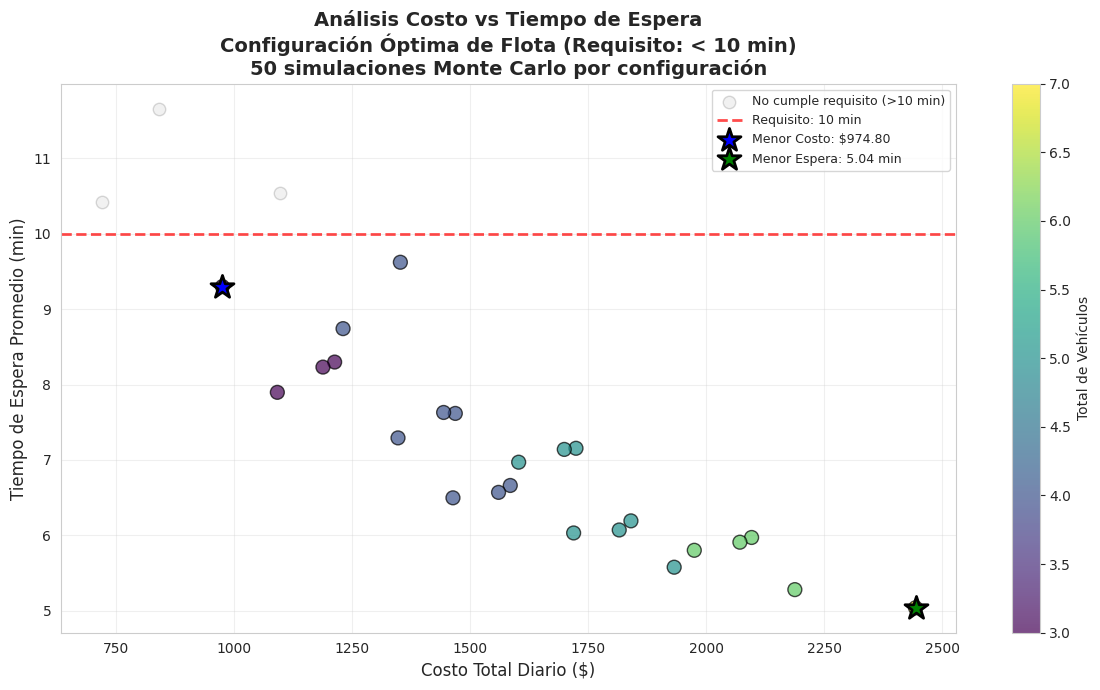

In [ ]:
# Gráfico de dispersión: Costo vs Tiempo de Espera
plt.figure(figsize=(12, 7))

# Separar configuraciones válidas e inválidas
valid_mask = df_results['avg_wait'] < 10
df_valid_plot = df_results[valid_mask]
df_invalid_plot = df_results[~valid_mask]

# Plotear configuraciones inválidas en gris
if len(df_invalid_plot) > 0:
    plt.scatter(df_invalid_plot['total_cost'], df_invalid_plot['avg_wait'], 
               c='lightgray', s=80, alpha=0.3, edgecolors='gray', 
               label='Does not meet requirement (>10 min)')

# Plotear configuraciones válidas
if len(df_valid_plot) > 0:
    scatter = plt.scatter(df_valid_plot['total_cost'], df_valid_plot['avg_wait'], 
                         c=df_valid_plot['total_vehicles'], cmap='viridis', 
                         s=100, alpha=0.7, edgecolors='black')
    plt.colorbar(scatter, label='Total de Vehículos')

# Requirement line
plt.axhline(y=10, color='red', linestyle='--', linewidth=2, label='Requirement: 10 min', alpha=0.7)

plt.xlabel('Daily Total Cost ($)', fontsize=12)
plt.ylabel('Average Waiting Time (min)', fontsize=12)
plt.title(f'Cost vs Waiting Time Analysis\nOptimal Fleet Configuration (Requirement: < 10 min)\n{N_SIMULATIONS} Monte Carlo simulations per configuration', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Mark best options (only if valid ones exist)
if len(df_valid_plot) > 0:
    best_cost = df_valid_plot.loc[df_valid_plot['total_cost'].idxmin()]
    best_wait = df_valid_plot.loc[df_valid_plot['avg_wait'].idxmin()]
    
    plt.scatter(best_cost['total_cost'], best_cost['avg_wait'], 
               color='blue', s=300, marker='*', edgecolors='black', linewidths=2, 
               label=f'Lowest Cost: ${best_cost["total_cost"]:.2f}', zorder=5)
    
    plt.scatter(best_wait['total_cost'], best_wait['avg_wait'], 
               color='green', s=300, marker='*', edgecolors='black', linewidths=2,
               label=f'Lowest Wait: {best_wait["avg_wait"]:.2f} min', zorder=5)

plt.legend(fontsize=9, loc='best')
plt.tight_layout()
plt.savefig('plots/01_costo_vs_espera.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: plots/01_costo_vs_espera.png")
plt.show()

✓ Gráfico guardado: plots/02_comparacion_configuraciones.png


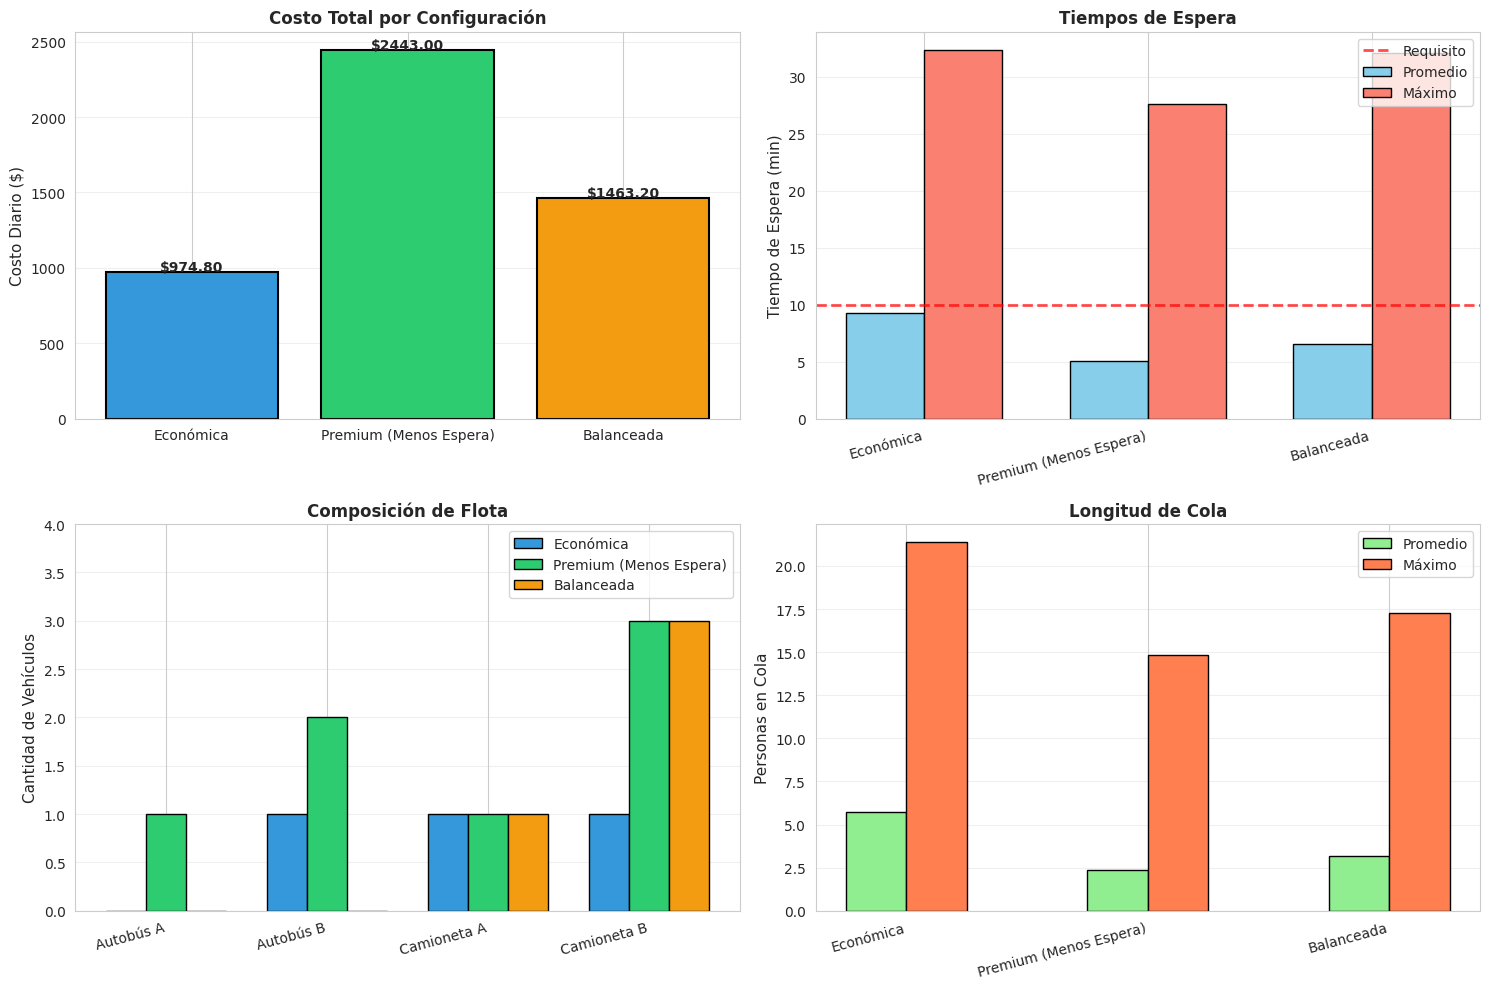

In [13]:
# Gráfico de barras comparativo
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Usar solo configuraciones válidas
df_for_comparison = df_valid if len(df_valid) > 0 else df_results

# Seleccionar configuraciones representativas
configs_to_compare = [
    df_for_comparison.loc[df_for_comparison['total_cost'].idxmin()],  # Menor costo
    df_for_comparison.loc[df_for_comparison['avg_wait'].idxmin()],     # Menor espera
    df_for_comparison.loc[((df_for_comparison['total_cost'] - df_for_comparison['total_cost'].min()) / 
                    (df_for_comparison['total_cost'].max() - df_for_comparison['total_cost'].min()) + 
                    (df_for_comparison['avg_wait'] - df_for_comparison['avg_wait'].min()) / 
                    (df_for_comparison['avg_wait'].max() - df_for_comparison['avg_wait'].min())).idxmin()]  # Balanceada
]

labels = ['Económica', 'Premium (Menos Espera)', 'Balanceada']
colors = ['#3498db', '#2ecc71', '#f39c12']

# Gráfico 1: Costos
costs = [c['total_cost'] for c in configs_to_compare]
axes[0,0].bar(labels, costs, color=colors, edgecolor='black', linewidth=1.5)
axes[0,0].set_ylabel('Costo Diario ($)', fontsize=11)
axes[0,0].set_title('Costo Total por Configuración', fontsize=12, fontweight='bold')
axes[0,0].grid(axis='y', alpha=0.3)
for i, v in enumerate(costs):
    axes[0,0].text(i, v + 5, f'${v:.2f}', ha='center', fontweight='bold')

# Gráfico 2: Tiempos de espera
avg_waits = [c['avg_wait'] for c in configs_to_compare]
max_waits = [c['max_wait'] for c in configs_to_compare]

x = np.arange(len(labels))
width = 0.35
axes[0,1].bar(x - width/2, avg_waits, width, label='Promedio', color='skyblue', edgecolor='black')
axes[0,1].bar(x + width/2, max_waits, width, label='Máximo', color='salmon', edgecolor='black')
axes[0,1].axhline(y=10, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Requisito')
axes[0,1].set_ylabel('Tiempo de Espera (min)', fontsize=11)
axes[0,1].set_title('Tiempos de Espera', fontsize=12, fontweight='bold')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(labels, rotation=15, ha='right')
axes[0,1].legend()
axes[0,1].grid(axis='y', alpha=0.3)

# Gráfico 3: Composición de flota
vehicle_names = ['Autobús A', 'Autobús B', 'Camioneta A', 'Camioneta B']
x = np.arange(len(vehicle_names))
width = 0.25

for i, (config, label, color) in enumerate(zip(configs_to_compare, labels, colors)):
    quantities = [config['autobus_a'], config['autobus_b'], 
                  config['camioneta_a'], config['camioneta_b']]
    axes[1,0].bar(x + i*width, quantities, width, label=label, color=color, edgecolor='black')

axes[1,0].set_ylabel('Cantidad de Vehículos', fontsize=11)
axes[1,0].set_title('Composición de Flota', fontsize=12, fontweight='bold')
axes[1,0].set_xticks(x + width)
axes[1,0].set_xticklabels(vehicle_names, rotation=15, ha='right')
axes[1,0].legend()
axes[1,0].grid(axis='y', alpha=0.3)
axes[1,0].set_ylim(0, 4)

# Gráfico 4: Longitud de cola
avg_queues = [c['avg_queue'] for c in configs_to_compare]
max_queues = [c['max_queue'] for c in configs_to_compare]

x = np.arange(len(labels))
axes[1,1].bar(x - width/2, avg_queues, width, label='Promedio', color='lightgreen', edgecolor='black')
axes[1,1].bar(x + width/2, max_queues, width, label='Máximo', color='coral', edgecolor='black')
axes[1,1].set_ylabel('Personas en Cola', fontsize=11)
axes[1,1].set_title('Longitud de Cola', fontsize=12, fontweight='bold')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(labels, rotation=15, ha='right')
axes[1,1].legend()
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/02_comparacion_configuraciones.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: plots/02_comparacion_configuraciones.png")
plt.show()

## Detailed Bus Behavior During the Day


In [14]:
# Simular una configuración específica con detalle
# Usaremos la configuración balanceada o económica

economica = configs_to_compare[0]
balanceada = configs_to_compare[2]

config_to_simulate = balanceada if balanceada['avg_wait'] < 10 else economica

print("="*100)
print(f"SIMULACIÓN DETALLADA: {config_to_simulate['fleet']}")
print("="*100)
print("\nNOTA: Los tiempos mostrados representan cuando el camión LLEGA a Glaxo.")
print("Cada vehículo realiza su PRIMER viaje exactamente a su hora de inicio.")
print("="*100)

# Recrear la simulación con tracking detallado
class DetailedFleetSimulator(FleetSimulator):
    def __init__(self, fleet_config, base_interarrivals, passenger_arrivals):
        super().__init__(fleet_config, base_interarrivals, passenger_arrivals)
        self.detailed_trips = []  # Guardar información detallada de cada viaje
        
    def run(self, period_data):
        """Ejecuta la simulación con tracking detallado"""
        self.period_data = period_data
        
        # Generar TODOS los viajes de TODOS los vehículos
        all_trips = []
        vehicle_counter = {}
        
        for vehicle, quantity in self.fleet.items():
            if quantity == 0:
                continue
            
            vehicle_counter[vehicle.name] = 0
            
            # Para cada vehículo de este tipo
            for vehicle_num in range(quantity):
                vehicle_counter[vehicle.name] += 1
                vehicle_id = f"{vehicle.name} #{vehicle_counter[vehicle.name]}"
                
                # Generar sus viajes durante su horario
                trips = self.generate_trips_for_vehicle(
                    vehicle, 
                    vehicle.start_min, 
                    vehicle.end_min
                )
                
                # Agregar cada viaje con su capacidad
                for trip_num, trip_time in enumerate(trips, 1):
                    all_trips.append({
                        'time': trip_time,
                        'vehicle': vehicle,
                        'vehicle_id': vehicle_id,
                        'trip_num': trip_num,
                        'capacity': vehicle.capacity
                    })
                    self.vehicle_usage[vehicle.name] += 1
        
        # Ordenar todos los viajes por tiempo
        all_trips.sort(key=lambda x: x['time'])
        
        # Procesar cada viaje
        for trip in all_trips:
            trip_time = trip['time']
            capacity = trip['capacity']
            vehicle_id = trip['vehicle_id']
            
            # Contar pasajeros esperando
            waiting = sum(1 for t in self.passenger_queue if t <= trip_time)
            self.queue_over_time.append({'time': trip_time, 'length': waiting})
            
            # Embarcar pasajeros
            boarded = 0
            while (self.passenger_queue and 
                   boarded < capacity and 
                   self.passenger_queue[0] <= trip_time):
                
                arrival = self.passenger_queue.pop(0)
                wait = trip_time - arrival
                self.wait_times.append(wait)
                boarded += 1
            
            # Guardar detalles del viaje
            hour = int(trip_time // 60) + 6
            minute = int(trip_time % 60)
            
            self.detailed_trips.append({
                'vehicle_id': vehicle_id,
                'trip_num': trip['trip_num'],
                'time': trip_time,
                'hour': hour,
                'minute': minute,
                'time_str': f"{hour:02d}:{minute:02d}",
                'queue_before': waiting,
                'passengers_boarded': boarded,
                'capacity': capacity,
                'occupancy_pct': (boarded / capacity * 100) if capacity > 0 else 0
            })
        
        # Último viaje se lleva a todos los que quedan
        if self.passenger_queue and len(all_trips) > 0:
            last_time = all_trips[-1]['time']
            remaining = len(self.passenger_queue)
            while self.passenger_queue:
                arrival = self.passenger_queue.pop(0)
                wait = last_time - arrival
                self.wait_times.append(wait)
            
            # Actualizar el último viaje con pasajeros adicionales
            if self.detailed_trips:
                self.detailed_trips[-1]['passengers_boarded'] += remaining
                self.detailed_trips[-1]['note'] = f'Último viaje (+{remaining} pasajeros extra)'
        
        return self.calculate_metrics()

# Ejecutar simulación detallada
passenger_arrivals_detail = generate_passenger_arrivals()
fleet_config_detail = {
    VEHICLES[0]: config_to_simulate['autobus_a'],
    VEHICLES[1]: config_to_simulate['autobus_b'],
    VEHICLES[2]: config_to_simulate['camioneta_a'],
    VEHICLES[3]: config_to_simulate['camioneta_b']
}

sim_detail = DetailedFleetSimulator(fleet_config_detail, None, passenger_arrivals_detail)
metrics_detail = sim_detail.run(period_data)

# Convertir a DataFrame para mejor visualización
df_trips = pd.DataFrame(sim_detail.detailed_trips)

print(f"\nTotal de viajes realizados: {len(df_trips)}")
print(f"Pasajeros transportados: {metrics_detail['passengers_served']}")
print(f"Tiempo de espera promedio: {metrics_detail['avg_wait']:.2f} minutos")
print(f"\n{'='*100}")
print("DETALLE DE VIAJES POR VEHÍCULO")
print(f"{'='*100}\n")

# Mostrar información por vehículo
for vehicle_id in df_trips['vehicle_id'].unique():
    vehicle_trips = df_trips[df_trips['vehicle_id'] == vehicle_id]
    
    print(f"\n{vehicle_id}")
    print("-" * 100)
    print(f"Total de viajes: {len(vehicle_trips)}")
    print(f"Pasajeros transportados: {vehicle_trips['passengers_boarded'].sum()}")
    print(f"Ocupación promedio: {vehicle_trips['occupancy_pct'].mean():.1f}%")
    print(f"Horario: {vehicle_trips['time_str'].iloc[0]} - {vehicle_trips['time_str'].iloc[-1]}")
    print(f"\nPrimeros 10 viajes:")
    print(vehicle_trips[['trip_num', 'time_str', 'queue_before', 'passengers_boarded', 'capacity', 'occupancy_pct']].head(10).to_string(index=False))
    if len(vehicle_trips) > 10:
        print(f"... ({len(vehicle_trips) - 10} viajes más)")

SIMULACIÓN DETALLADA: 1 Camioneta A, 3 Camioneta B

NOTA: Los tiempos mostrados representan cuando el camión LLEGA a Glaxo.
Cada vehículo realiza su PRIMER viaje exactamente a su hora de inicio.

Total de viajes realizados: 135
Pasajeros transportados: 437
Tiempo de espera promedio: 5.57 minutos

DETALLE DE VIAJES POR VEHÍCULO


Camioneta A #1
----------------------------------------------------------------------------------------------------
Total de viajes: 30
Pasajeros transportados: 115
Ocupación promedio: 20.2%
Horario: 06:00 - 19:56

Primeros 10 viajes:
 trip_num time_str  queue_before  passengers_boarded  capacity  occupancy_pct
        1    06:00             0                   0        19       0.000000
        2    06:28            10                  10        19      52.631579
        3    07:05             2                   2        19      10.526316
        4    07:45             4                   4        19      21.052632
        5    08:18             4            


VISUALIZACIÓN DEL TIMELINE DE OPERACIONES

✓ Gráfico guardado: plots/03_timeline_operaciones.png
✓ Gráfico guardado: plots/03_timeline_operaciones.png


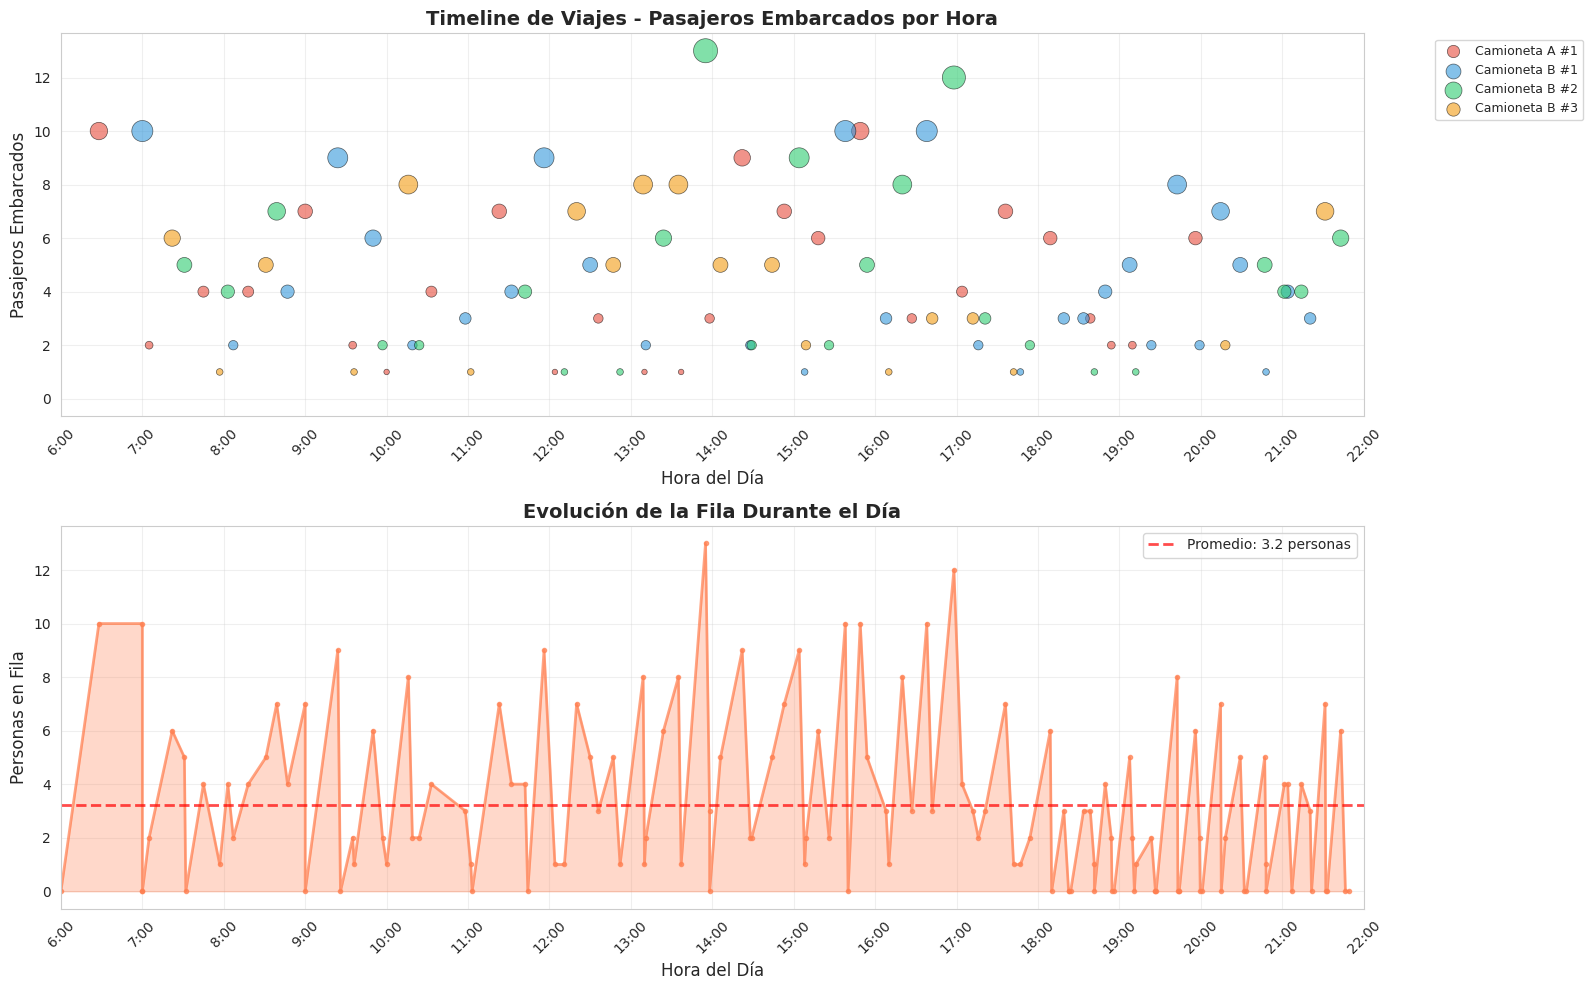


ESTADÍSTICAS GENERALES:
----------------------------------------------------------------------------------------------------
Fila máxima: 13 personas
Fila promedio: 3.22 personas
Ocupación promedio de vehículos: 22.7%
Viajes con ocupación completa (100%): 1 de 135
Viajes con ocupación > 80%: 2 de 135


In [15]:
# Visualización del timeline de operaciones
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

print("\n" + "="*100)
print("VISUALIZACIÓN DEL TIMELINE DE OPERACIONES")
print("="*100 + "\n")

# Asignar colores únicos a cada vehículo
unique_vehicles = df_trips['vehicle_id'].unique()
colors_map = {}
color_palette = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22', '#34495e']
for i, veh in enumerate(unique_vehicles):
    colors_map[veh] = color_palette[i % len(color_palette)]

# Plotear cada viaje como un punto
for vehicle_id in unique_vehicles:
    vehicle_trips = df_trips[df_trips['vehicle_id'] == vehicle_id]
    
    # Crear scatter plot
    scatter = axes[0].scatter(
        vehicle_trips['time'] / 60 + 6,  # Convertir a horas del día
        vehicle_trips['passengers_boarded'],
        s=vehicle_trips['occupancy_pct'] * 3,  # Tamaño según ocupación
        c=colors_map[vehicle_id],
        alpha=0.6,
        edgecolors='black',
        linewidth=0.5,
        label=vehicle_id
    )

axes[0].set_xlabel('Hora del Día', fontsize=12)
axes[0].set_ylabel('Pasajeros Embarcados', fontsize=12)
axes[0].set_title('Timeline de Viajes - Pasajeros Embarcados por Hora', fontsize=14, fontweight='bold')
axes[0].set_xlim(6, 22)
axes[0].grid(True, alpha=0.3)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

# Configurar ticks de horas
hour_ticks = range(6, 23)
axes[0].set_xticks(hour_ticks)
axes[0].set_xticklabels([f'{h}:00' for h in hour_ticks], rotation=45)

# Gráfico 2: Evolución de la cola durante el día
axes[1].plot(df_trips['time'] / 60 + 6, df_trips['queue_before'], 
            color='coral', linewidth=2, marker='o', markersize=3, alpha=0.7)
axes[1].fill_between(df_trips['time'] / 60 + 6, df_trips['queue_before'], 
                     alpha=0.3, color='coral')
axes[1].set_xlabel('Hora del Día', fontsize=12)
axes[1].set_ylabel('Personas en Fila', fontsize=12)
axes[1].set_title('Evolución de la Fila Durante el Día', fontsize=14, fontweight='bold')
axes[1].set_xlim(6, 22)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(hour_ticks)
axes[1].set_xticklabels([f'{h}:00' for h in hour_ticks], rotation=45)

# Marcar promedio de cola
avg_queue_line = df_trips['queue_before'].mean()
axes[1].axhline(y=avg_queue_line, color='red', linestyle='--', linewidth=2, 
               label=f'Promedio: {avg_queue_line:.1f} personas', alpha=0.7)
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.savefig('plots/03_timeline_operaciones.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: plots/03_timeline_operaciones.png")
plt.show()

# Estadísticas adicionales
print(f"\nESTADÍSTICAS GENERALES:")
print("-" * 100)
print(f"Fila máxima: {df_trips['queue_before'].max()} personas")
print(f"Fila promedio: {df_trips['queue_before'].mean():.2f} personas")
print(f"Ocupación promedio de vehículos: {df_trips['occupancy_pct'].mean():.1f}%")
print(f"Viajes con ocupación completa (100%): {(df_trips['occupancy_pct'] >= 100).sum()} de {len(df_trips)}")
print(f"Viajes con ocupación > 80%: {(df_trips['occupancy_pct'] >= 80).sum()} de {len(df_trips)}")

In [16]:
# Tabla detallada de todos los viajes del día
print("\n" + "="*120)
print("REGISTRO COMPLETO DE VIAJES DEL DÍA")
print("="*120)

# Crear tabla completa con toda la información
df_trips_display = df_trips.copy()
df_trips_display['Vehículo'] = df_trips_display['vehicle_id']
df_trips_display['Viaje #'] = df_trips_display['trip_num']
df_trips_display['Hora'] = df_trips_display['time_str']
df_trips_display['Cola'] = df_trips_display['queue_before']
df_trips_display['Embarcados'] = df_trips_display['passengers_boarded']
df_trips_display['Capacidad'] = df_trips_display['capacity']
df_trips_display['Ocupación %'] = df_trips_display['occupancy_pct'].round(1)

# Mostrar tabla completa en bloques
print(f"\nMostrando todos los {len(df_trips_display)} viajes del día:\n")

# Dividir en bloques de 20 para mejor legibilidad
block_size = 25
for i in range(0, len(df_trips_display), block_size):
    block = df_trips_display.iloc[i:i+block_size]
    print(f"\nViajes {i+1} a {min(i+block_size, len(df_trips_display))}:")
    print("-" * 120)
    print(block[['Vehículo', 'Viaje #', 'Hora', 'Cola', 'Embarcados', 'Capacidad', 'Ocupación %']].to_string(index=False))
    
    if i + block_size < len(df_trips_display):
        print("\n" + "...")


REGISTRO COMPLETO DE VIAJES DEL DÍA

Mostrando todos los 135 viajes del día:


Viajes 1 a 25:
------------------------------------------------------------------------------------------------------------------------
      Vehículo  Viaje #  Hora  Cola  Embarcados  Capacidad  Ocupación %
Camioneta A #1        1 06:00     0           0         19          0.0
Camioneta A #1        2 06:28    10          10         19         52.6
Camioneta B #1        1 07:00    10          10         13         76.9
Camioneta B #2        1 07:00     0           0         13          0.0
Camioneta B #3        1 07:00     0           0         13          0.0
Camioneta A #1        3 07:05     2           2         19         10.5
Camioneta B #3        2 07:22     6           6         13         46.2
Camioneta B #2        2 07:31     5           5         13         38.5
Camioneta B #1        2 07:32     0           0         13          0.0
Camioneta A #1        4 07:45     4           4         19      

In [17]:
# Análisis por franja horaria
print("\n" + "="*100)
print("ANÁLISIS POR FRANJA HORARIA")
print("="*100 + "\n")

# Definir franjas horarias
franjas_analisis = [
    ('6:00-8:00 (Madrugada)', 6, 8),
    ('8:00-10:00 (Mañana)', 8, 10),
    ('10:00-13:00 (Media Mañana)', 10, 13),
    ('13:00-17:00 (Hora Pico)', 13, 17),
    ('17:00-22:00 (Tarde-Noche)', 17, 22)
]

franjas_data = []

for franja_name, start_h, end_h in franjas_analisis:
    # Filtrar viajes en esta franja
    franja_trips = df_trips[(df_trips['hour'] >= start_h) & (df_trips['hour'] < end_h)]
    
    if len(franja_trips) == 0:
        continue
    
    # Calcular estadísticas
    total_viajes = len(franja_trips)
    total_pasajeros = franja_trips['passengers_boarded'].sum()
    cola_promedio = franja_trips['queue_before'].mean()
    cola_maxima = franja_trips['queue_before'].max()
    ocupacion_promedio = franja_trips['occupancy_pct'].mean()
    
    # Vehículos activos en esta franja
    vehiculos_activos = franja_trips['vehicle_id'].nunique()
    
    franjas_data.append({
        'Franja': franja_name,
        'Viajes': total_viajes,
        'Pasajeros': total_pasajeros,
        'Pasaj/Viaje': f"{total_pasajeros/total_viajes:.1f}" if total_viajes > 0 else "0",
        'Cola Prom': f"{cola_promedio:.1f}",
        'Cola Máx': int(cola_maxima),
        'Ocupación %': f"{ocupacion_promedio:.1f}",
        'Vehículos': vehiculos_activos
    })
    
df_franjas = pd.DataFrame(franjas_data)
print(df_franjas.to_string(index=False))

print("\n" + "="*100)
print("INTERPRETACIÓN:")
print("-" * 100)

# Encontrar franja crítica
franja_mayor_cola = df_franjas.loc[df_franjas['Cola Máx'].idxmax()]
print(f"\n• Franja con mayor congestión: {franja_mayor_cola['Franja']}")
print(f"  - Cola máxima: {franja_mayor_cola['Cola Máx']} personas")
print(f"  - {franja_mayor_cola['Viajes']} viajes realizados con {franja_mayor_cola['Vehículos']} vehículos activos")

# Encontrar mejor ocupación
idx_mejor_ocupacion = df_franjas['Ocupación %'].astype(float).idxmax()
franja_mejor_ocupacion = df_franjas.loc[idx_mejor_ocupacion]
print(f"\n• Mejor ocupación de vehículos: {franja_mejor_ocupacion['Franja']}")
print(f"  - Ocupación promedio: {franja_mejor_ocupacion['Ocupación %']}%")

print("\n" + "="*100)


ANÁLISIS POR FRANJA HORARIA

                    Franja  Viajes  Pasajeros Pasaj/Viaje Cola Prom  Cola Máx Ocupación %  Vehículos
     6:00-8:00 (Madrugada)      11         38         3.5       3.5        10        23.0          4
       8:00-10:00 (Mañana)      14         53         3.8       3.8         9        26.9          4
10:00-13:00 (Media Mañana)      20         68         3.4       3.4         9        24.2          4
   13:00-17:00 (Hora Pico)      31        157         5.1       5.1        13        35.8          4
 17:00-22:00 (Tarde-Noche)      59        121         2.1       2.0         8        14.3          4

INTERPRETACIÓN:
----------------------------------------------------------------------------------------------------

• Franja con mayor congestión: 13:00-17:00 (Hora Pico)
  - Cola máxima: 13 personas
  - 31 viajes realizados con 4 vehículos activos

• Mejor ocupación de vehículos: 13:00-17:00 (Hora Pico)
  - Ocupación promedio: 35.8%



## Performance Metrics - Detailed Graphs


✓ Gráfico guardado: plots/04_ocupacion_vehiculos.png


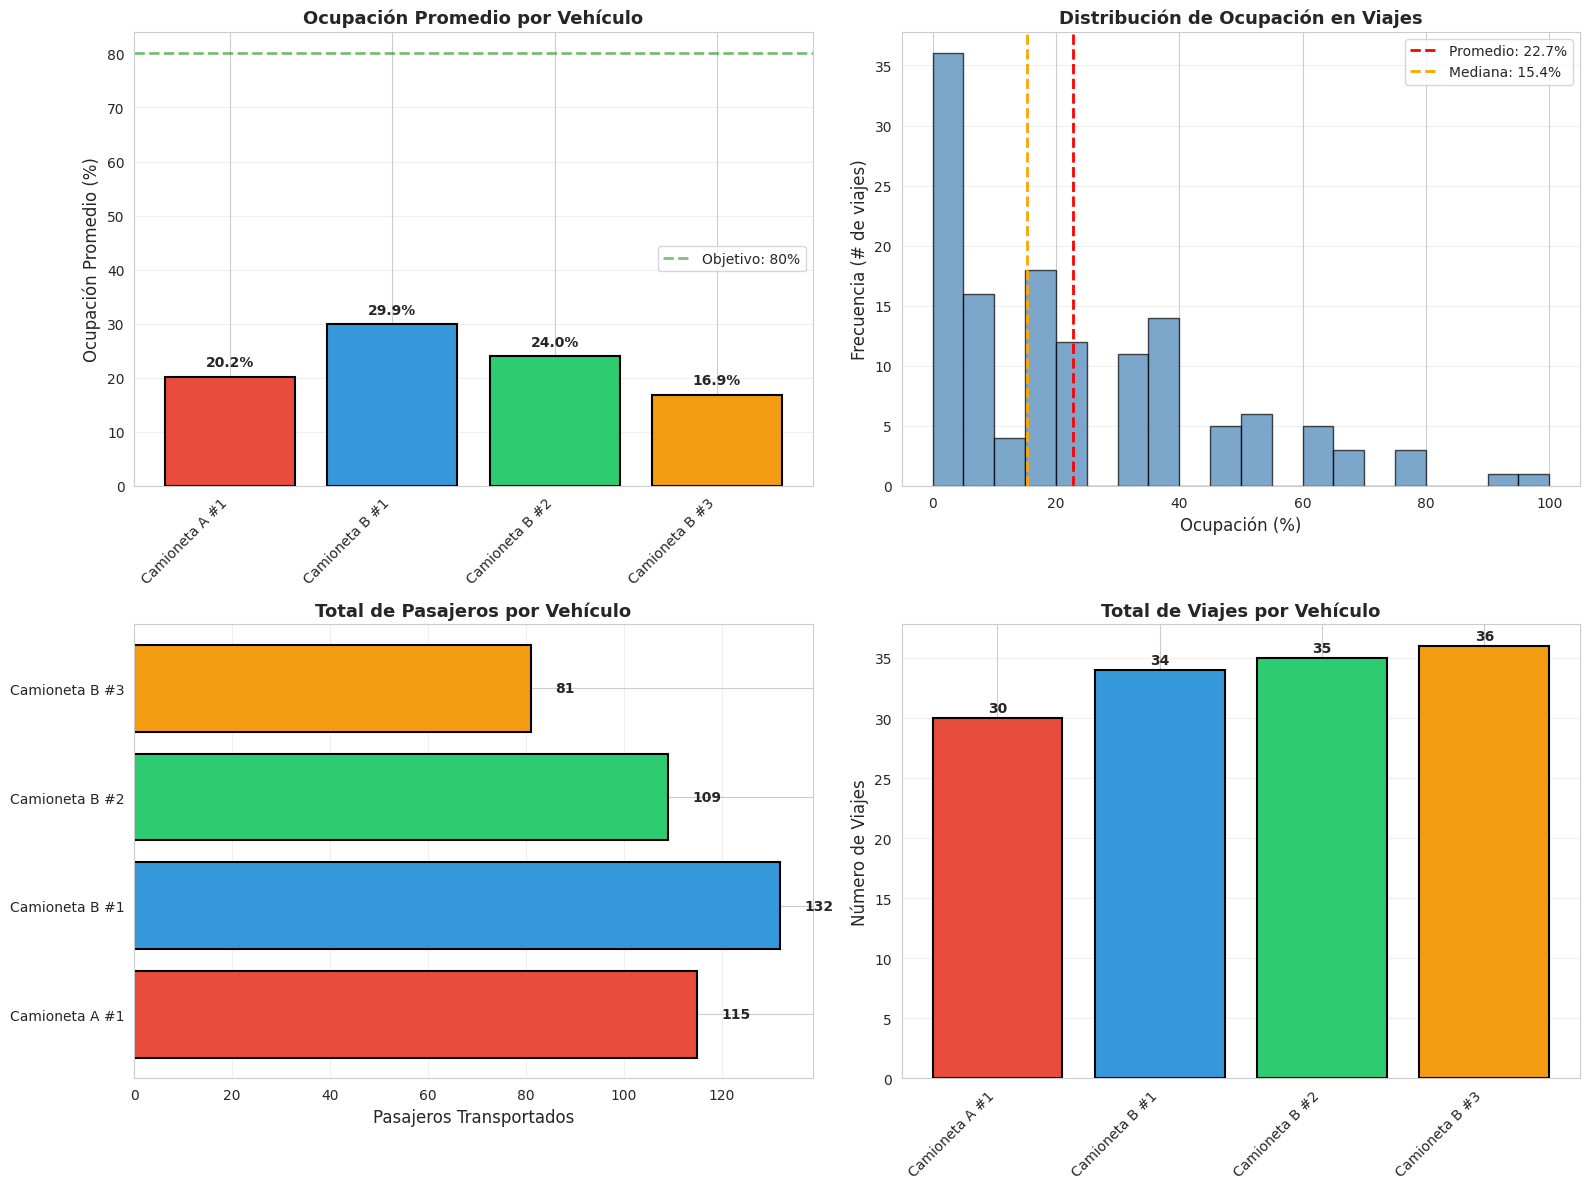


RESUMEN DE OCUPACIÓN
      Vehículo  Ocupación %  Pasajeros Totales  Viajes
Camioneta A #1    20.175439                115      30
Camioneta B #1    29.864253                132      34
Camioneta B #2    23.956044                109      35
Camioneta B #3    16.880342                 81      36

Ocupación global promedio: 22.7%
Ocupación global mediana: 15.4%
Pasajeros totales transportados: 437
Viajes totales: 135
Pasajeros por viaje (promedio): 3.2


In [18]:
# Gráfica 1: Ocupación Promedio por Vehículo
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1.1 Ocupación promedio por tipo de vehículo
vehicle_occupancy = df_trips.groupby('vehicle_id').agg({
    'occupancy_pct': 'mean',
    'passengers_boarded': 'sum',
    'trip_num': 'count'
}).reset_index()
vehicle_occupancy.columns = ['Vehículo', 'Ocupación %', 'Pasajeros Totales', 'Viajes']

colors_vehicles = [colors_map[v] for v in vehicle_occupancy['Vehículo']]
bars = axes[0,0].bar(range(len(vehicle_occupancy)), vehicle_occupancy['Ocupación %'], 
                     color=colors_vehicles, edgecolor='black', linewidth=1.5)
axes[0,0].set_ylabel('Ocupación Promedio (%)', fontsize=12)
axes[0,0].set_title('Ocupación Promedio por Vehículo', fontsize=13, fontweight='bold')
axes[0,0].set_xticks(range(len(vehicle_occupancy)))
axes[0,0].set_xticklabels(vehicle_occupancy['Vehículo'], rotation=45, ha='right')
axes[0,0].axhline(y=80, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Objetivo: 80%')
axes[0,0].grid(axis='y', alpha=0.3)
axes[0,0].legend()

# Añadir etiquetas con valores
for i, (v, occ) in enumerate(zip(vehicle_occupancy['Vehículo'], vehicle_occupancy['Ocupación %'])):
    axes[0,0].text(i, occ + 2, f'{occ:.1f}%', ha='center', fontweight='bold', fontsize=10)

# 1.2 Distribución de ocupación (histograma)
axes[0,1].hist(df_trips['occupancy_pct'], bins=20, color='steelblue', 
               edgecolor='black', alpha=0.7)
axes[0,1].axvline(x=df_trips['occupancy_pct'].mean(), color='red', 
                  linestyle='--', linewidth=2, label=f'Promedio: {df_trips["occupancy_pct"].mean():.1f}%')
axes[0,1].axvline(x=df_trips['occupancy_pct'].median(), color='orange', 
                  linestyle='--', linewidth=2, label=f'Mediana: {df_trips["occupancy_pct"].median():.1f}%')
axes[0,1].set_xlabel('Ocupación (%)', fontsize=12)
axes[0,1].set_ylabel('Frecuencia (# de viajes)', fontsize=12)
axes[0,1].set_title('Distribución de Ocupación en Viajes', fontsize=13, fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(axis='y', alpha=0.3)

# 1.3 Pasajeros transportados por vehículo
axes[1,0].barh(range(len(vehicle_occupancy)), vehicle_occupancy['Pasajeros Totales'],
               color=colors_vehicles, edgecolor='black', linewidth=1.5)
axes[1,0].set_xlabel('Pasajeros Transportados', fontsize=12)
axes[1,0].set_title('Total de Pasajeros por Vehículo', fontsize=13, fontweight='bold')
axes[1,0].set_yticks(range(len(vehicle_occupancy)))
axes[1,0].set_yticklabels(vehicle_occupancy['Vehículo'])
axes[1,0].grid(axis='x', alpha=0.3)

# Añadir etiquetas
for i, (v, pax) in enumerate(zip(vehicle_occupancy['Vehículo'], vehicle_occupancy['Pasajeros Totales'])):
    axes[1,0].text(pax + 5, i, f'{pax}', va='center', fontweight='bold', fontsize=10)

# 1.4 Número de viajes por vehículo
axes[1,1].bar(range(len(vehicle_occupancy)), vehicle_occupancy['Viajes'],
              color=colors_vehicles, edgecolor='black', linewidth=1.5)
axes[1,1].set_ylabel('Número de Viajes', fontsize=12)
axes[1,1].set_title('Total de Viajes por Vehículo', fontsize=13, fontweight='bold')
axes[1,1].set_xticks(range(len(vehicle_occupancy)))
axes[1,1].set_xticklabels(vehicle_occupancy['Vehículo'], rotation=45, ha='right')
axes[1,1].grid(axis='y', alpha=0.3)

# Añadir etiquetas
for i, (v, trips) in enumerate(zip(vehicle_occupancy['Vehículo'], vehicle_occupancy['Viajes'])):
    axes[1,1].text(i, trips + 0.5, f'{trips}', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('plots/04_ocupacion_vehiculos.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: plots/04_ocupacion_vehiculos.png")
plt.show()

# Imprimir resumen
print("\n" + "="*100)
print("RESUMEN DE OCUPACIÓN")
print("="*100)
print(vehicle_occupancy.to_string(index=False))
print(f"\nOcupación global promedio: {df_trips['occupancy_pct'].mean():.1f}%")
print(f"Ocupación global mediana: {df_trips['occupancy_pct'].median():.1f}%")
print(f"Pasajeros totales transportados: {df_trips['passengers_boarded'].sum()}")
print(f"Viajes totales: {len(df_trips)}")
print(f"Pasajeros por viaje (promedio): {df_trips['passengers_boarded'].mean():.1f}")

✓ Gráfico guardado: plots/05_evolucion_ocupacion_horaria.png


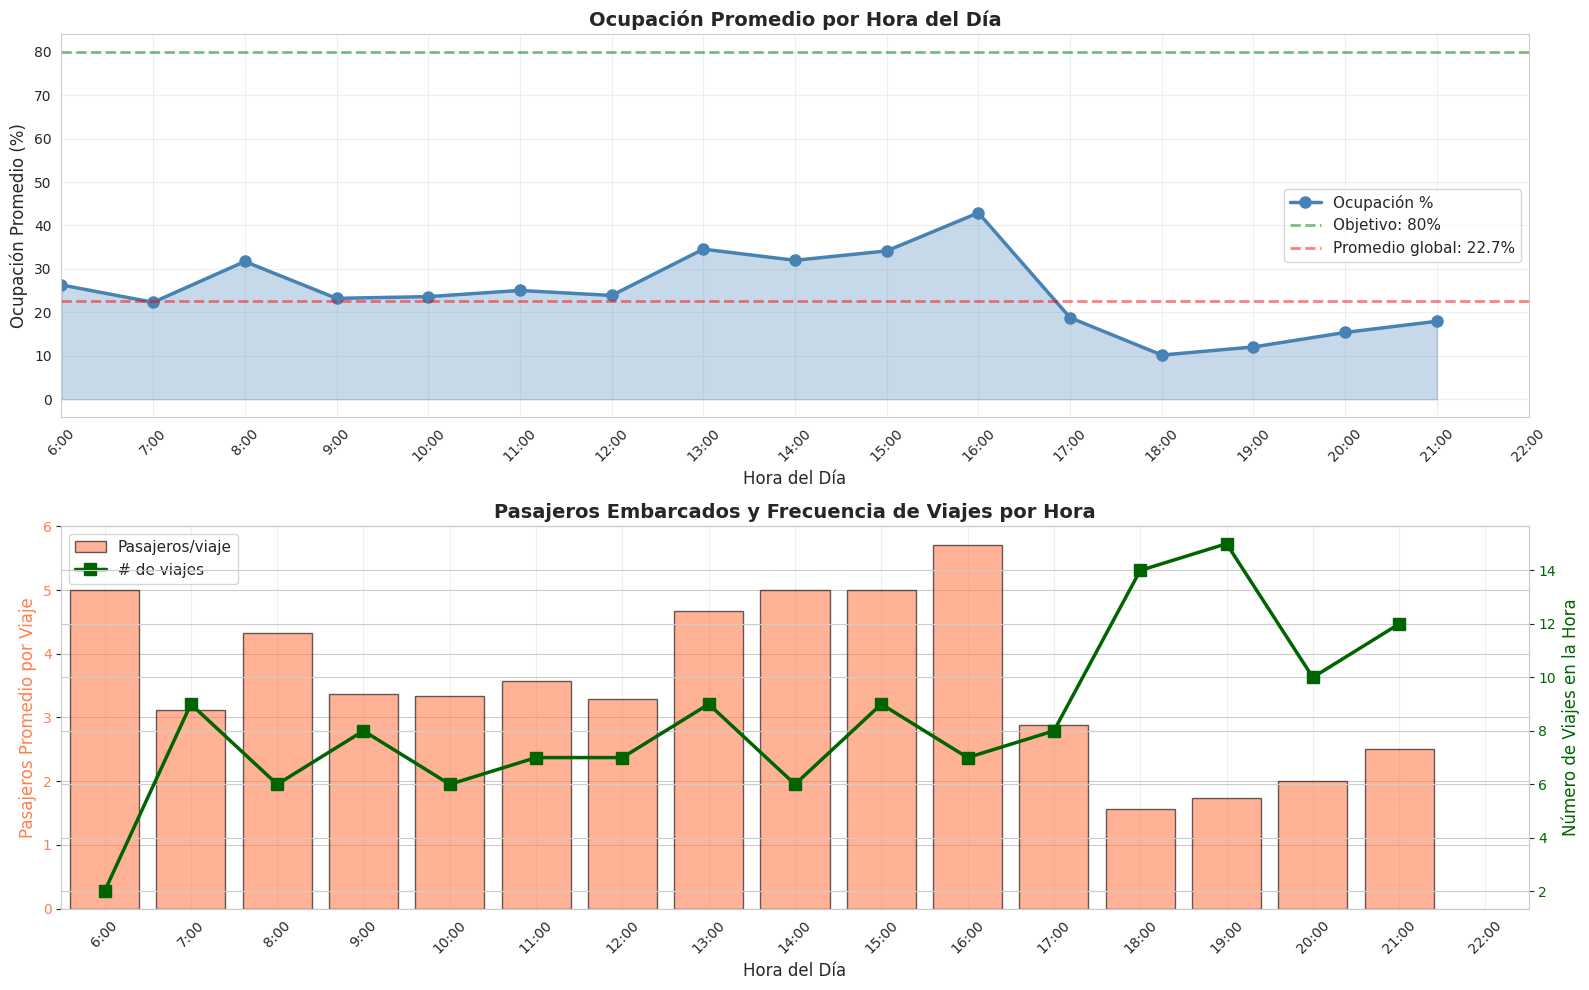


OCUPACIÓN Y DEMANDA POR HORA
 Hora  Ocupación %  Pasajeros/Viaje  # Viajes
 6:00         26.3              5.0         2
 7:00         22.3              3.1         9
 8:00         31.7              4.3         6
 9:00         23.2              3.4         8
10:00         23.6              3.3         6
11:00         25.0              3.6         7
12:00         23.9              3.3         7
13:00         34.5              4.7         9
14:00         32.0              5.0         6
15:00         34.1              5.0         9
16:00         42.9              5.7         7
17:00         18.8              2.9         8
18:00         10.2              1.6        14
19:00         12.0              1.7        15
20:00         15.4              2.0        10
21:00         17.9              2.5        12

• Hora con mayor ocupación: 16:00 (42.9%)
• Hora con menor ocupación: 18:00 (10.2%)
• Hora con mayor demanda: 16:00 (5.7 pasajeros/viaje)


In [19]:
# Gráfica 2: Evolución de Ocupación a lo largo del día
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# 2.1 Ocupación por hora del día
df_trips['hour_bucket'] = df_trips['hour']
hourly_occupancy = df_trips.groupby('hour_bucket').agg({
    'occupancy_pct': 'mean',
    'passengers_boarded': 'mean',
    'trip_num': 'count'
}).reset_index()

axes[0].plot(hourly_occupancy['hour_bucket'], hourly_occupancy['occupancy_pct'], 
            marker='o', linewidth=2.5, markersize=8, color='steelblue', label='Ocupación %')
axes[0].fill_between(hourly_occupancy['hour_bucket'], hourly_occupancy['occupancy_pct'], 
                     alpha=0.3, color='steelblue')
axes[0].axhline(y=80, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Objetivo: 80%')
axes[0].axhline(y=df_trips['occupancy_pct'].mean(), color='red', linestyle='--', 
               linewidth=2, alpha=0.5, label=f'Promedio global: {df_trips["occupancy_pct"].mean():.1f}%')
axes[0].set_xlabel('Hora del Día', fontsize=12)
axes[0].set_ylabel('Ocupación Promedio (%)', fontsize=12)
axes[0].set_title('Ocupación Promedio por Hora del Día', fontsize=14, fontweight='bold')
axes[0].set_xlim(6, 22)
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=11)
axes[0].set_xticks(range(6, 23))
axes[0].set_xticklabels([f'{h}:00' for h in range(6, 23)], rotation=45)

# 2.2 Promedio de pasajeros embarcados por hora
ax2 = axes[1].twinx()  # Crear segundo eje Y

# Barras de pasajeros promedio
bars = axes[1].bar(hourly_occupancy['hour_bucket'], hourly_occupancy['passengers_boarded'], 
                   alpha=0.6, color='coral', edgecolor='black', label='Pasajeros/viaje')
axes[1].set_xlabel('Hora del Día', fontsize=12)
axes[1].set_ylabel('Pasajeros Promedio por Viaje', fontsize=12, color='coral')
axes[1].tick_params(axis='y', labelcolor='coral')

# Línea de número de viajes
line = ax2.plot(hourly_occupancy['hour_bucket'], hourly_occupancy['trip_num'], 
               marker='s', linewidth=2.5, markersize=8, color='darkgreen', label='# de viajes')
ax2.set_ylabel('Número de Viajes en la Hora', fontsize=12, color='darkgreen')
ax2.tick_params(axis='y', labelcolor='darkgreen')

axes[1].set_title('Pasajeros Embarcados y Frecuencia de Viajes por Hora', fontsize=14, fontweight='bold')
axes[1].set_xlim(5.5, 22.5)
axes[1].set_xticks(range(6, 23))
axes[1].set_xticklabels([f'{h}:00' for h in range(6, 23)], rotation=45)
axes[1].grid(True, alpha=0.3, axis='x')

# Combinar leyendas
lines1, labels1 = axes[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axes[1].legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11)

plt.tight_layout()
plt.savefig('plots/05_evolucion_ocupacion_horaria.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: plots/05_evolucion_ocupacion_horaria.png")
plt.show()

# Estadísticas por hora
print("\n" + "="*100)
print("OCUPACIÓN Y DEMANDA POR HORA")
print("="*100)
hourly_occupancy.columns = ['Hora', 'Ocupación %', 'Pasajeros/Viaje', '# Viajes']
hourly_occupancy['Hora'] = hourly_occupancy['Hora'].apply(lambda x: f'{x}:00')
hourly_occupancy['Ocupación %'] = hourly_occupancy['Ocupación %'].round(1)
hourly_occupancy['Pasajeros/Viaje'] = hourly_occupancy['Pasajeros/Viaje'].round(1)
print(hourly_occupancy.to_string(index=False))

# Identificar horas críticas
max_ocupacion_hour = hourly_occupancy.loc[hourly_occupancy['Ocupación %'].idxmax()]
min_ocupacion_hour = hourly_occupancy.loc[hourly_occupancy['Ocupación %'].idxmin()]
max_demanda_hour = hourly_occupancy.loc[hourly_occupancy['Pasajeros/Viaje'].idxmax()]

print(f"\n• Hora con mayor ocupación: {max_ocupacion_hour['Hora']} ({max_ocupacion_hour['Ocupación %']}%)")
print(f"• Hora con menor ocupación: {min_ocupacion_hour['Hora']} ({min_ocupacion_hour['Ocupación %']}%)")
print(f"• Hora con mayor demanda: {max_demanda_hour['Hora']} ({max_demanda_hour['Pasajeros/Viaje']:.1f} pasajeros/viaje)")

✓ Gráfico guardado: plots/06_top_configuraciones.png


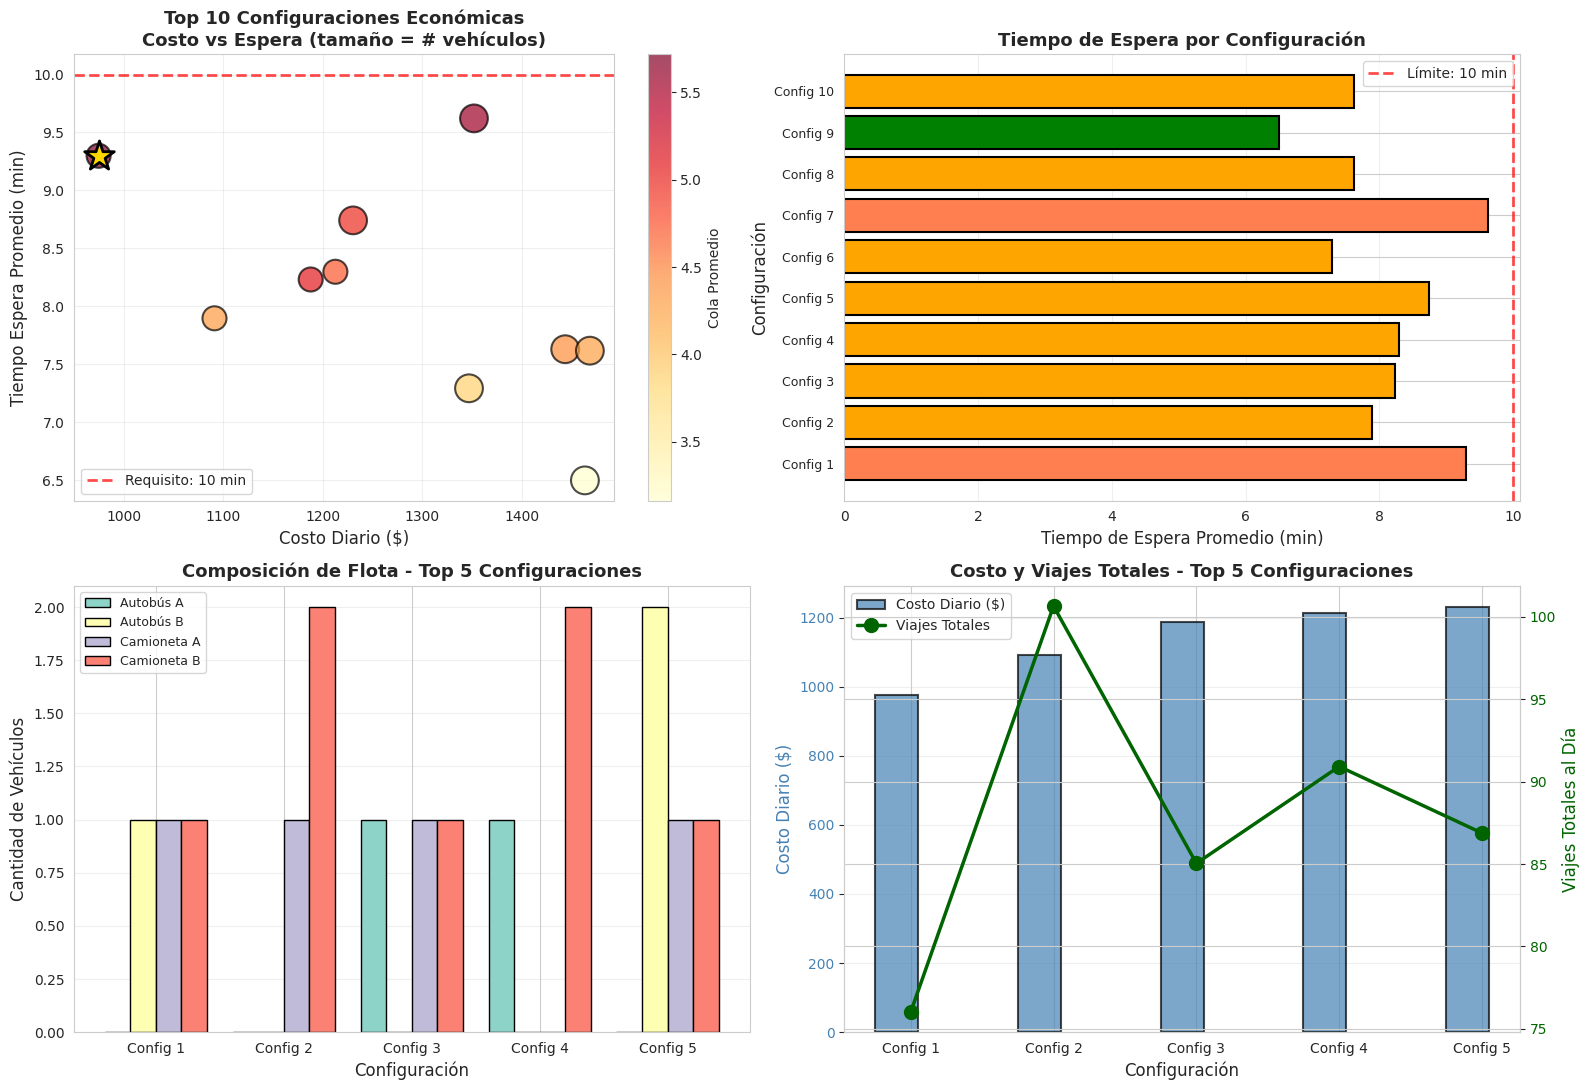


TOP 10 CONFIGURACIONES MÁS ECONÓMICAS
                                                 fleet  total_cost  avg_wait  max_wait  avg_queue  total_vehicles  total_trips  passengers_served
             1 Autobús B, 1 Camioneta A, 1 Camioneta B       974.8  9.298628 32.304527   5.718660               3        76.02             426.68
                          1 Camioneta A, 2 Camioneta B      1091.2  7.896126 32.481946   4.328636               3       100.66             428.12
             1 Autobús A, 1 Camioneta A, 1 Camioneta B      1187.8  8.231030 30.727649   5.079965               3        85.04             429.86
                            1 Autobús A, 2 Camioneta B      1212.6  8.297817 32.891409   4.710748               3        90.92             421.26
             2 Autobús B, 1 Camioneta A, 1 Camioneta B      1230.4  8.741220 32.579543   4.960304               4        86.88             421.96
             1 Autobús B, 1 Camioneta A, 2 Camioneta B      1346.8  7.291983 32.80600

In [20]:
# Gráfica 3: Comparación de Configuraciones (Top 10 más económicas)
fig, axes = plt.subplots(2, 2, figsize=(16, 11))

# Seleccionar top 10 configuraciones más económicas que cumplen requisito
top_10_configs = df_valid.nsmallest(10, 'total_cost') if len(df_valid) >= 10 else df_valid

# 3.1 Costo vs Tiempo de Espera (Top 10)
scatter = axes[0,0].scatter(top_10_configs['total_cost'], top_10_configs['avg_wait'],
                           s=top_10_configs['total_vehicles']*100, 
                           c=top_10_configs['avg_queue'], 
                           cmap='YlOrRd', alpha=0.7, edgecolors='black', linewidth=1.5)
axes[0,0].axhline(y=10, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Requisito: 10 min')
axes[0,0].set_xlabel('Costo Diario ($)', fontsize=12)
axes[0,0].set_ylabel('Tiempo Espera Promedio (min)', fontsize=12)
axes[0,0].set_title('Top 10 Configuraciones Económicas\nCosto vs Espera (tamaño = # vehículos)', 
                    fontsize=13, fontweight='bold')
axes[0,0].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[0,0])
cbar.set_label('Cola Promedio', fontsize=10)
axes[0,0].legend()

# Marcar mejor configuración
best_idx = top_10_configs['total_cost'].idxmin()
best_config = top_10_configs.loc[best_idx]
axes[0,0].scatter(best_config['total_cost'], best_config['avg_wait'], 
                 s=500, marker='*', color='gold', edgecolors='black', 
                 linewidths=2, zorder=10, label='Mejor opción')

# 3.2 Tiempo de espera promedio por configuración
axes[0,1].barh(range(len(top_10_configs)), top_10_configs['avg_wait'],
              color=['green' if x < 7 else 'orange' if x < 9 else 'coral' 
                     for x in top_10_configs['avg_wait']],
              edgecolor='black', linewidth=1.5)
axes[0,1].axvline(x=10, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Límite: 10 min')
axes[0,1].set_xlabel('Tiempo de Espera Promedio (min)', fontsize=12)
axes[0,1].set_ylabel('Configuración', fontsize=12)
axes[0,1].set_title('Tiempo de Espera por Configuración', fontsize=13, fontweight='bold')
axes[0,1].set_yticks(range(len(top_10_configs)))
axes[0,1].set_yticklabels([f"Config {i+1}" for i in range(len(top_10_configs))], fontsize=9)
axes[0,1].grid(axis='x', alpha=0.3)
axes[0,1].legend()

# 3.3 Composición de flota (Top 5)
top_5 = top_10_configs.head(5)
vehicle_types = ['Autobús A', 'Autobús B', 'Camioneta A', 'Camioneta B']
x_pos = np.arange(len(top_5))
width = 0.2

for i, (vtype, col) in enumerate(zip(vehicle_types, 
                                      ['autobus_a', 'autobus_b', 'camioneta_a', 'camioneta_b'])):
    values = top_5[col].values
    axes[1,0].bar(x_pos + i*width, values, width, 
                 label=vtype, edgecolor='black', linewidth=1)

axes[1,0].set_xlabel('Configuración', fontsize=12)
axes[1,0].set_ylabel('Cantidad de Vehículos', fontsize=12)
axes[1,0].set_title('Composición de Flota - Top 5 Configuraciones', fontsize=13, fontweight='bold')
axes[1,0].set_xticks(x_pos + width * 1.5)
axes[1,0].set_xticklabels([f'Config {i+1}' for i in range(len(top_5))], fontsize=10)
axes[1,0].legend(fontsize=9)
axes[1,0].grid(axis='y', alpha=0.3)

# 3.4 Costo total y número de viajes
ax_twin = axes[1,1].twinx()

# Barras de costo
bars1 = axes[1,1].bar(x_pos - width/2, top_5['total_cost'].values, 
                      width*1.5, label='Costo Diario ($)', 
                      color='steelblue', edgecolor='black', linewidth=1.5, alpha=0.7)
axes[1,1].set_xlabel('Configuración', fontsize=12)
axes[1,1].set_ylabel('Costo Diario ($)', fontsize=12, color='steelblue')
axes[1,1].tick_params(axis='y', labelcolor='steelblue')

# Línea de viajes totales
line1 = ax_twin.plot(x_pos, top_5['total_trips'].values, 
                     marker='o', linewidth=2.5, markersize=10, 
                     color='darkgreen', label='Viajes Totales')
ax_twin.set_ylabel('Viajes Totales al Día', fontsize=12, color='darkgreen')
ax_twin.tick_params(axis='y', labelcolor='darkgreen')

axes[1,1].set_title('Costo y Viajes Totales - Top 5 Configuraciones', fontsize=13, fontweight='bold')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels([f'Config {i+1}' for i in range(len(top_5))], fontsize=10)
axes[1,1].grid(axis='y', alpha=0.3)

# Combinar leyendas
lines1, labels1 = axes[1,1].get_legend_handles_labels()
lines2, labels2 = ax_twin.get_legend_handles_labels()
axes[1,1].legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('plots/06_top_configuraciones.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: plots/06_top_configuraciones.png")
plt.show()

# Tabla resumen
print("\n" + "="*120)
print("TOP 10 CONFIGURACIONES MÁS ECONÓMICAS")
print("="*120)
summary_cols = ['fleet', 'total_cost', 'avg_wait', 'max_wait', 'avg_queue', 
                'total_vehicles', 'total_trips', 'passengers_served']
print(top_10_configs[summary_cols].to_string(index=False))
print("\n" + "="*120)

## Recommendations for the Client


In [21]:
# Usar solo configuraciones válidas (< 10 min)
df_for_recommendations = df_valid if len(df_valid) > 0 else df_results

# Identificar las 3 mejores opciones
economica = df_for_recommendations.loc[df_for_recommendations['total_cost'].idxmin()]
premium = df_for_recommendations.loc[df_for_recommendations['avg_wait'].idxmin()]

# Balanceada: minimizar suma normalizada de costo y espera
df_for_recommendations['score'] = ((df_for_recommendations['total_cost'] - df_for_recommendations['total_cost'].min()) / 
                       (df_for_recommendations['total_cost'].max() - df_for_recommendations['total_cost'].min()) + 
                       (df_for_recommendations['avg_wait'] - df_for_recommendations['avg_wait'].min()) / 
                       (df_for_recommendations['avg_wait'].max() - df_for_recommendations['avg_wait'].min()))
balanceada = df_for_recommendations.loc[df_for_recommendations['score'].idxmin()]

print("\n" + "="*100)
print("RECOMENDACIONES PARA EL CLIENTE")
print("="*100)
print(f"\n⚠️  REQUISITO PRINCIPAL: Tiempo de espera promedio < 10 minutos")
print(f"✓  Configuraciones que cumplen: {len(df_valid)} de {len(df_results)}")

print("\n1. OPCIÓN ECONÓMICA (Minimizar Costos)")
print("-" * 80)
print(f"   Flota: {economica['fleet']}")
print(f"   Total de vehículos: {economica['total_vehicles']}")
print(f"   Viajes totales al día: {economica['total_trips']}")
print(f"   Costo diario: ${economica['total_cost']:.2f}")
print(f"   Costo mensual estimado (30 días): ${economica['total_cost'] * 30:.2f}")
print(f"   Costo anual estimado (365 días): ${economica['total_cost'] * 365:.2f}")
print(f"   {'✓' if economica['avg_wait'] < 10 else '✗'} Tiempo de espera promedio: {economica['avg_wait']:.2f} minutos")
print(f"   Tiempo de espera máximo: {economica['max_wait']:.2f} minutos")
print(f"   Cola promedio: {economica['avg_queue']:.2f} personas")

print("\n2. OPCIÓN PREMIUM (Minimizar Tiempo de Espera)")
print("-" * 80)
print(f"   Flota: {premium['fleet']}")
print(f"   Total de vehículos: {premium['total_vehicles']}")
print(f"   Viajes totales al día: {premium['total_trips']}")
print(f"   Costo diario: ${premium['total_cost']:.2f}")
print(f"   Costo mensual estimado (30 días): ${premium['total_cost'] * 30:.2f}")
print(f"   Costo anual estimado (365 días): ${premium['total_cost'] * 365:.2f}")
print(f"   {'✓' if premium['avg_wait'] < 10 else '✗'} Tiempo de espera promedio: {premium['avg_wait']:.2f} minutos")
print(f"   Tiempo de espera máximo: {premium['max_wait']:.2f} minutos")
print(f"   Cola promedio: {premium['avg_queue']:.2f} personas")

print("\n3. OPCIÓN BALANCEADA (Mejor Relación Costo-Beneficio)")
print("-" * 80)
print(f"   Flota: {balanceada['fleet']}")
print(f"   Total de vehículos: {balanceada['total_vehicles']}")
print(f"   Viajes totales al día: {balanceada['total_trips']}")
print(f"   Costo diario: ${balanceada['total_cost']:.2f}")
print(f"   Costo mensual estimado (30 días): ${balanceada['total_cost'] * 30:.2f}")
print(f"   Costo anual estimado (365 días): ${balanceada['total_cost'] * 365:.2f}")
print(f"   {'✓' if balanceada['avg_wait'] < 10 else '✗'} Tiempo de espera promedio: {balanceada['avg_wait']:.2f} minutos")
print(f"   Tiempo de espera máximo: {balanceada['max_wait']:.2f} minutos")
print(f"   Cola promedio: {balanceada['avg_queue']:.2f} personas")

print("\n" + "="*100)
print("ANÁLISIS COMPARATIVO")
print("="*100)
ahorro_anual = (premium['total_cost'] - economica['total_cost']) * 365
reduccion_espera = economica['avg_wait'] - premium['avg_wait']
diferencia_viajes = premium['total_trips'] - economica['total_trips']

print(f"\nAhorro anual (Económica vs Premium): ${ahorro_anual:.2f}")
print(f"Reducción de espera (Premium vs Económica): {reduccion_espera:.2f} minutos")
print(f"Diferencia en viajes diarios (Premium vs Económica): {diferencia_viajes} viajes")

if balanceada['total_cost'] != economica['total_cost']:
    print(f"\nLa opción BALANCEADA ofrece:")
    print(f"  - {((balanceada['total_cost'] - economica['total_cost']) / economica['total_cost'] * 100):.1f}% más costo que la económica")
    print(f"  - {((economica['avg_wait'] - balanceada['avg_wait']) / economica['avg_wait'] * 100):.1f}% menos espera que la económica")
    if premium['total_cost'] != balanceada['total_cost']:
        print(f"  - {((premium['total_cost'] - balanceada['total_cost']) / premium['total_cost'] * 100):.1f}% menos costo que la premium")
    print(f"  - {balanceada['total_trips']} viajes totales al día")

print("\n" + "="*100)
print("RECOMENDACIÓN FINAL")
print("="*100)

# Determinar mejor recomendación
if economica['avg_wait'] < 10:
    print(f"\n✓ Se recomienda la OPCIÓN ECONÓMICA:")
    print(f"  {economica['fleet']}")
    print(f"\nEsta configuración cumple con el requisito de tiempo de espera < 10 minutos")
    print(f"y minimiza los costos operativos. Con un tiempo de espera promedio de")
    print(f"{economica['avg_wait']:.2f} minutos, {economica['total_trips']} viajes diarios,")
    print(f"y un costo diario de ${economica['total_cost']:.2f},")
    print(f"ofrece la mejor relación costo-beneficio.")
elif balanceada['avg_wait'] < 10:
    print(f"\n✓ Se recomienda la OPCIÓN BALANCEADA:")
    print(f"  {balanceada['fleet']}")
    print(f"\nEsta configuración proporciona un equilibrio óptimo entre costo operativo")
    print(f"y calidad de servicio, cumpliendo con el requisito de < 10 minutos de espera.")
    print(f"Realiza {balanceada['total_trips']} viajes al día.")
else:
    print(f"\n⚠️ ADVERTENCIA: Se requieren más vehículos para cumplir con el requisito")
    print(f"La mejor opción disponible es:")
    print(f"  {premium['fleet']}")
    print(f"Con tiempo de espera de {premium['avg_wait']:.2f} minutos")
    print(f"y {premium['total_trips']} viajes al día")

print("="*100)


RECOMENDACIONES PARA EL CLIENTE

⚠️  REQUISITO PRINCIPAL: Tiempo de espera promedio < 10 minutos
✓  Configuraciones que cumplen: 24 de 27

1. OPCIÓN ECONÓMICA (Minimizar Costos)
--------------------------------------------------------------------------------
   Flota: 1 Autobús B, 1 Camioneta A, 1 Camioneta B
   Total de vehículos: 3
   Viajes totales al día: 76.02
   Costo diario: $974.80
   Costo mensual estimado (30 días): $29244.00
   Costo anual estimado (365 días): $355802.00
   ✓ Tiempo de espera promedio: 9.30 minutos
   Tiempo de espera máximo: 32.30 minutos
   Cola promedio: 5.72 personas

2. OPCIÓN PREMIUM (Minimizar Tiempo de Espera)
--------------------------------------------------------------------------------
   Flota: 1 Autobús A, 2 Autobús B, 1 Camioneta A, 3 Camioneta B
   Total de vehículos: 7
   Viajes totales al día: 177.36
   Costo diario: $2443.00
   Costo mensual estimado (30 días): $73290.00
   Costo anual estimado (365 días): $891695.00
   ✓ Tiempo de espera

## Export Results


✓ Gráfico guardado: plots/07_variabilidad_montecarlo.png


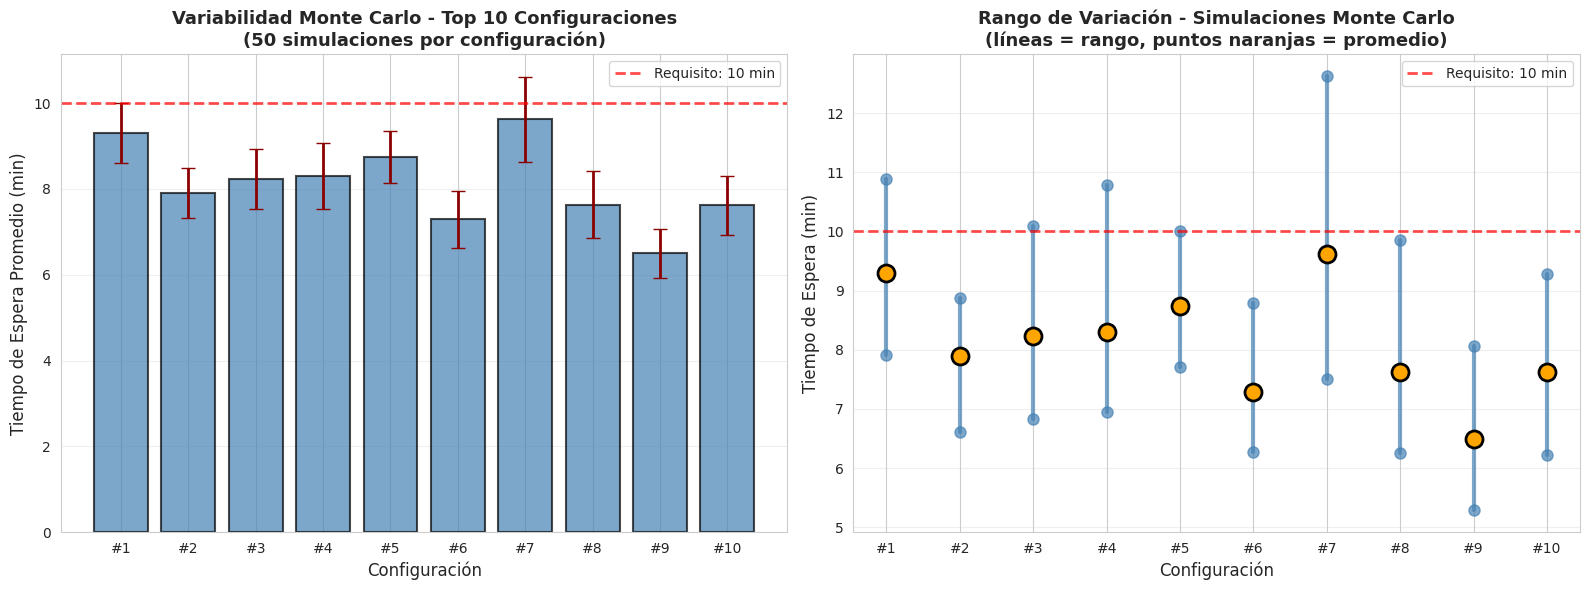


ANÁLISIS DE VARIABILIDAD MONTE CARLO

Configuración con menor variabilidad (std_avg_wait):
  Flota: 1 Autobús A, 2 Autobús B, 1 Camioneta A, 3 Camioneta B
  Tiempo espera promedio: 5.04 ± 0.35 min
  Rango: [4.30, 5.88] min
  Costo: $2443.00

Configuración óptima (menor costo):
  Flota: 1 Autobús B, 1 Camioneta A, 1 Camioneta B
  Tiempo espera promedio: 9.30 ± 0.70 min
  Rango: [7.91, 10.88] min
  Costo: $974.80


In [22]:
# Visualización de la variabilidad de Monte Carlo
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Top 10 configuraciones con barras de error
top_10_with_std = df_valid.nsmallest(10, 'total_cost') if len(df_valid) >= 10 else df_valid

x_pos = np.arange(len(top_10_with_std))
axes[0].bar(x_pos, top_10_with_std['avg_wait'], 
           yerr=top_10_with_std['std_avg_wait'],
           capsize=5, alpha=0.7, color='steelblue', edgecolor='black', linewidth=1.5,
           error_kw={'elinewidth': 2, 'ecolor': 'darkred'})
axes[0].axhline(y=10, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Requisito: 10 min')
axes[0].set_xlabel('Configuración', fontsize=12)
axes[0].set_ylabel('Tiempo de Espera Promedio (min)', fontsize=12)
axes[0].set_title(f'Variabilidad Monte Carlo - Top 10 Configuraciones\n({N_SIMULATIONS} simulaciones por configuración)', 
                 fontsize=13, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f'#{i+1}' for i in range(len(top_10_with_std))], fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].legend()

# Gráfico 2: Rango min-max de tiempos de espera
for i, row in enumerate(top_10_with_std.itertuples()):
    # Línea vertical del rango
    axes[1].plot([i, i], [row.min_avg_wait, row.max_avg_wait], 
                'o-', linewidth=3, markersize=8, color='steelblue', alpha=0.7)
    # Punto central (promedio)
    axes[1].scatter(i, row.avg_wait, s=150, color='orange', 
                   edgecolors='black', linewidth=2, zorder=10)

axes[1].axhline(y=10, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Requisito: 10 min')
axes[1].set_xlabel('Configuración', fontsize=12)
axes[1].set_ylabel('Tiempo de Espera (min)', fontsize=12)
axes[1].set_title(f'Rango de Variación - Simulaciones Monte Carlo\n(líneas = rango, puntos naranjas = promedio)', 
                 fontsize=13, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f'#{i+1}' for i in range(len(top_10_with_std))], fontsize=10)
axes[1].grid(axis='y', alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig('plots/07_variabilidad_montecarlo.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: plots/07_variabilidad_montecarlo.png")
plt.show()

# Estadísticas de variabilidad
print("\n" + "="*100)
print("ANÁLISIS DE VARIABILIDAD MONTE CARLO")
print("="*100)
print(f"\nConfiguración con menor variabilidad (std_avg_wait):")
most_stable = df_valid.loc[df_valid['std_avg_wait'].idxmin()]
print(f"  Flota: {most_stable['fleet']}")
print(f"  Tiempo espera promedio: {most_stable['avg_wait']:.2f} ± {most_stable['std_avg_wait']:.2f} min")
print(f"  Rango: [{most_stable['min_avg_wait']:.2f}, {most_stable['max_avg_wait']:.2f}] min")
print(f"  Costo: ${most_stable['total_cost']:.2f}")

print(f"\nConfiguración óptima (menor costo):")
economica = df_valid.loc[df_valid['total_cost'].idxmin()]
print(f"  Flota: {economica['fleet']}")
print(f"  Tiempo espera promedio: {economica['avg_wait']:.2f} ± {economica['std_avg_wait']:.2f} min")
print(f"  Rango: [{economica['min_avg_wait']:.2f}, {economica['max_avg_wait']:.2f}] min")
print(f"  Costo: ${economica['total_cost']:.2f}")
print("="*100)

In [23]:
# Guardar los resultados completos
df_results_export = df_results[['fleet', 'autobus_a', 'autobus_b', 'camioneta_a', 'camioneta_b',
                                 'total_cost', 'avg_wait', 'median_wait', 'max_wait', 
                                 'avg_queue', 'max_queue', 'passengers_served', 
                                 'std_avg_wait', 'std_avg_queue', 
                                 'min_avg_wait', 'max_avg_wait']].copy()

df_results_export = df_results_export.sort_values('score' if 'score' in df_results.columns else 'total_cost')
df_results_export.to_csv('data/resultados_optimizacion_flota.csv', index=False)

print("✓ Resultados exportados a 'data/resultados_optimizacion_flota.csv'")
print(f"Total de configuraciones analizadas: {len(df_results_export)}")
print(f"Simulaciones Monte Carlo por configuración: {N_SIMULATIONS}")
print(f"\nColumnas exportadas incluyen:")
print("  - Configuración de flota y costos")
print("  - Métricas promedio (avg_wait, avg_queue, etc.)")
print("  - Desviaciones estándar (std_avg_wait, std_avg_queue)")
print("  - Valores mínimos y máximos de las simulaciones")

✓ Resultados exportados a 'data/resultados_optimizacion_flota.csv'
Total de configuraciones analizadas: 27
Simulaciones Monte Carlo por configuración: 50

Columnas exportadas incluyen:
  - Configuración de flota y costos
  - Métricas promedio (avg_wait, avg_queue, etc.)
  - Desviaciones estándar (std_avg_wait, std_avg_queue)
  - Valores mínimos y máximos de las simulaciones
